 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

# Outlook

In this notebook, you will code a naive actor-critic algorithm in the tabular case. Then you will tune it using grid search and Bayesian optimization, potentially using the [optuna](https://optuna.readthedocs.io/en/stable/) library.
Finally, you will get the best hyper-parameters obtained with both methods and perform a statistical test to see if there is a statistically significant difference between these methods and with respect to naive hyper-parameter values.


## Install libraries

In [1]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install 'easypip>=1.2.0'")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("swig")
easyinstall("bbrl>=0.2.2")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")
easyinstall("optuna")
easyinstall("gymnasium")
easyinstall("mazemdp")

import numpy as np
import os
from typing import List  # Ensure compatibility with Python 3.8 and below, with the same functionality as 'list'.

import hydra
import optuna
import yaml
from omegaconf import OmegaConf, DictConfig

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

In [2]:
import torch
import torch.nn as nn

In [3]:
import gymnasium as gym

from bbrl.utils.chrono import Chrono

import matplotlib
import matplotlib.pyplot as plt

from mazemdp.toolbox import sample_categorical
from mazemdp.mdp import Mdp
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
from functools import partial

matplotlib.use("TkAgg")
matplotlib.use("Agg")

Matplotlib backend: module://matplotlib_inline.backend_inline


In [4]:
env = gym.make(
    "MazeMDP-v0",
    kwargs={"width": 5, "height": 5, "ratio": 0.2, "hit": 0.0},
    render_mode="human",
)
# env.reset()
# env.unwrapped.init_draw("The maze")

# Step 1: Coding the naive Actor-critic algorithm 

We consider the naive actor-critic algorithm with a categorical policy.
The algorithm learns a critic with the standard temporal difference mechanism
using a learning rate $\alpha_{critic}$.

We consider a value-based critic $V(s)$. The extension to an action value function $Q(s,a)$ is straightforward.

To update the critic, the algorithm computes the temporal difference error:

$$\delta_t = r(s_t, a_t) + \gamma V^{(n)}(s_{t+1})-V^{(n)}(s_t).$$

Then it applies it to the critic:

$$V^{(n+1)}(s_t) = V^{(n)}(s_t) + \alpha_{critic} \delta_t.$$

To update the actor, the general idea is the same, using the temporal difference error with another learning rate $\alpha_{actor}$.

However, naively applying the same learning rule would not ensure that the probabilities of all actions in a state sum to 1.
Besides, when the temporal difference error $\delta_t$ is negative, it may happen that the probability of an action gets negative or null, which raises an issue when applying renormalization.

So, instead of applying the naive rule, we apply the following one:
$$ 
\pi_{temp}(a_t|s_t) =  \begin{cases}
\pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t & \mathrm{if } \pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t > 10^{-8}\\
10^{-8} & \mathrm{otherwise.} \\
\end{cases}
$$

Then we can apply renormalization so that the probabilities of actions still sum to 1, with
$$
\forall a, \pi^{(i+1)}(a|s_t) = \frac{\pi_{temp}^{(i+1)}(a|s_t)} {\sum_{a'} \pi_{temp}^{(i+1)}(a'|s_t)}
$$ with
$$ 
\pi_{temp}^{(i+1)}(a|s_t) =  \begin{cases}
\pi_{temp}(a|s_t) & \mathrm{if } a = a_t\\
\pi^{(i)}(a|s_t) & \mathrm{otherwise.} \\
\end{cases}
$$

## Exercise 1

### 1. Code the naive actor-critic algorithm as specified above.

Some hints:

- a good idea to build this code it to take inspiration from the code of Q-learning, to add an actor (a categorical policy), both learning rates,
and to take care about the renormalization function.

- for the next steps of this lab, having a function to repeatedly call your actor-critic algorithm and save the learning trajectories and
norms of the value function is a good idea.

In [5]:
# Exercise 1.1

# naive actor-critic algotithm
def naive_actor_critic(
        mdp: MazeMDPEnv,
        alpha_critic: float,
        alpha_actor: float,
        nb_episodes: int = 100,
        timeout: int = 50,
        render: bool = True
)->tuple[np.ndarray, List[float], List[int]]:
    # initialize the state value function and policy pi
    v = np.zeros(mdp.nb_states)
    pi = np.ones((mdp.nb_states,mdp.action_space.n))/mdp.action_space.n

    v_norms = []
    time_list = []

    mdp.timeout = timeout  # set maximum step of each epoch

    if render:
        mdp.init_draw("Naive Actor-Critic")

    for _ in range(nb_episodes):
        x, _ = mdp.reset(uniform=True)
        cpt = 0
        terminated = False
        truncated = False

        while not(terminated or truncated):
            if render:
                mdp.draw_v_pi(v, pi.argmax(axis = 1))

            # choose action from policy
            u = np.random.choice(len(pi[x]), p = pi[x])

            y, r, terminated, truncated, _ = mdp.step(u)

            # update critic(value function)
            delta = r + mdp.gamma*(1-terminated) * v[y] - v[x]
            v[x] = v[x] + alpha_critic * delta

            # update actor (policy)
            pi_temp = np.copy(pi[x])
            pi_temp[u] = max(pi_temp[u]+alpha_actor*delta, 1e-8)

            # normalization
            pi[x] = pi_temp/np.sum(pi_temp)

            x = y
            cpt += 1
            # print(f"Episode {_}, Steps: {cpt}, Value: {v[x]}, Delta: {delta}")

        v_norms.append(np.linalg.norm(v))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(v, pi.argmax(axis = 1))
    
    return v, v_norms, time_list

# call repeatedly
def repeat(actor_critic, mdp, alpha_critic, alpha_actor,nb_episodes=50, timeout=50, render=False, nb_repeat=10):
    v_repeat = []
    v_norm_repeat = []
    time_list_repeat = []
    for _ in range(nb_repeat):
        v, v_norms, time_list = actor_critic(mdp,alpha_critic=alpha_critic, alpha_actor=alpha_actor, nb_episodes=nb_episodes, timeout=timeout, render=render)
        v_repeat.append(v)
        v_norm_repeat.append(v_norms)
        time_list_repeat.append(time_list)
    return v_repeat, v_norm_repeat, time_list_repeat


In [6]:
alpha_critic = 0.5
alpha_actor = 0.5

v_repeat, v_norm_repeat, time_list_repeat = repeat(naive_actor_critic, env.unwrapped, alpha_critic, alpha_actor)

### 2. Provide a plot function

Your plot function should show the evolution through time of number of steps the agent takes to find the reward in the maze.
If your algorithm works, this number of steps should decrease through time.

Your plot function should also show a mean and a standard deviation (or some more advanced statistics) over a collection of learning runs.

In [7]:
# Exercise 1.2

def plot_steps_evaluation(
        mdp: MazeMDPEnv,
        alpha_critic: float,
        alpha_actor: float,
        nb_episodes: int = 100,
        timeout: int = 50,
        nb_repeats: int = 10,
        render: bool = False
):
    _, _, time_lists = repeat(naive_actor_critic, mdp, alpha_critic, alpha_actor, nb_episodes=nb_episodes, timeout=timeout,render = render, nb_repeat=nb_repeats)
    mean_steps = np.mean(time_lists, axis = 0)
    std_steps = np.std(time_lists,axis = 0)

    plt.figure()
    plt.plot(mean_steps, label = "Mean Steps", color = 'b')
    plt.fill_between(range(nb_episodes), mean_steps-std_steps, mean_steps+std_steps, color = 'b', alpha = 0.2, label = "Standard Deviation")
    plt.xlabel('Episodes')
    plt.ylabel('Steps to find reward')
    plt.title('Steps to Find Reward Over Time')
    plt.legend()
    plt.show()
    plt.savefig("StepNumber.png")


## Actor-critic hyper-parameters

To represent the hyper-parameters of the experiments performed in this notebook, we suggest using the dictionary below.
This dictionary can be read using omegaconf.
Using it is not mandatory.
You can also change the value of hyper-parameters or environment parameters at will.

In [8]:
ac_params = {
    "save_curves": False,
    "save_heatmap": True,
    "mdp": {
        "name": "MazeMDP-v0",
        "width": 5,
        "height": 5,
        "ratio": 0.2,
        "render_mode": "human", # "rgb_array"
        },
        
    "log_dir": "./tmp",
    "video_dir": "./tmp/videos",

    "nb_episodes": 100,
    "timeout": 200,
    "render": False, # True, # 
    "nb_repeats": 5,

    "alpha_critic": 0.5,
    "alpha_actor": 0.5,
    }

### 3. Test your code

Once everything looks OK, save the obtained plot for your lab report

In [9]:
# Exercise 1.3

config = OmegaConf.create(ac_params)
env = gym.make(
        config.mdp.name, 
        kwargs={"width":config.mdp.width, "height": config.mdp.height, "ratio": config.mdp.ratio},
        render_mode = config.mdp.render_mode,
)

plot_steps_evaluation(
  env.unwrapped,
  alpha_critic = config.alpha_critic,
  alpha_actor = config.alpha_actor,
  nb_episodes=config.nb_episodes,
  timeout=config.timeout,
  nb_repeats=config.nb_repeats,
  render=config.render
    )


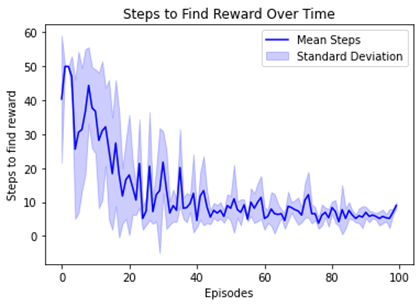

# Step 2: Tuning hyper-parameters

In this part, you have to optimize two hyper-parameters of the actor-critic algorithm, namely the actor and critic learning rates.
You have to do so using a simple grid search method and some Bayesian optimization method.
For the latter, we suggest using the default sampler from [optuna](https://optuna.readthedocs.io/en/stable/).
Follow the above link to understand how optuna works.
Note that it also supports grid search and many other hyper-parameters tuning algorithms.

You should make sure that the hyper-parameters tuning algorithms that you compare benefit from the same training budget
We suggest 400 training runs overall for each method,
which means 20 values each for the actor and the critic learning rates in the case of grid search.

## Exercise 2

### 1. Perform hyper-parameters tuning with two algorithms as suggested above.

### 2. Provide a "heatmap" of the norm of the value function given the hyper-parameters, after training for each pair of hyper-parameters.

### 3. Collect the value of the best hyper-parameters found with each algorithm. You will need them for Step 3.

### 4. Include in your report the heatmaps and the best hyper-parameters found for each method.

In [10]:
# Exercise 2

# grid search methode
import itertools
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def grid_search(
            mdp:MazeMDPEnv,
            alpha_critic_values: np.ndarray,
            alpha_actor_values: np.ndarray,
            nb_episodes: int = 100,
            timeout: int = 50,
            nb_repeats: int = 5,
            render: bool = False,
            plot_heatmap: bool = True
) -> tuple[tuple[float, float], float, list[tuple[float, float, float]]]:
    
    best_v_norm = float('-inf')
    best_params = None
    results = []
    param_grid = list(itertools.product(alpha_critic_values,alpha_actor_values))

    for alpha_critic,alpha_actor in tqdm(param_grid, desc = "Grid Search"):
        v_norms_repeat = []
        for _ in range(nb_repeats):
            v, v_norms, time_list = naive_actor_critic(mdp, alpha_critic, alpha_actor, nb_episodes, timeout, render)
            v_norms_repeat.append(v_norms[-1])
        
        avg_v_norm = np.mean(v_norms_repeat)
        results.append((round(alpha_critic,2), round(alpha_actor,2), avg_v_norm))
        if avg_v_norm > best_v_norm:
            best_v_norm = avg_v_norm
            best_params = (alpha_critic, alpha_actor)
    
    # heatmap of the norm
    if plot_heatmap:
        plt.clf() 
        df = pd.DataFrame(results, columns=['alpha_critic', 'alpha_actor', 'v_norm'])
        sns.heatmap(df.pivot(index='alpha_critic', columns='alpha_actor', values='v_norm'), annot=False, cmap='viridis')
        plt.title('Heatmap of Value Function Norm With Grid Search')
        plt.xlabel('Alpha Critic')
        plt.ylabel('Alpha Actor')
        plt.gca().set_xlim(0, 20)
        plt.gca().set_ylim(0, 20)
        plt.show()
        plt.savefig('heatmap_grid.png')

    return best_params, best_v_norm, results

alpha_critic_values = np.linspace(0.1, 1, 20)
alpha_actor_values = np.linspace(0.1, 1, 20)
best_params_grid, best_v_nrom, results_grid = grid_search(env.unwrapped,alpha_critic_values, alpha_actor_values, nb_repeats=1)
print(best_params_grid)
print(best_v_nrom)


Grid Search: 100%|██████████| 400/400 [00:47<00:00,  8.47it/s]


(0.9052631578947369, 0.8578947368421053)
3.0746979419728957


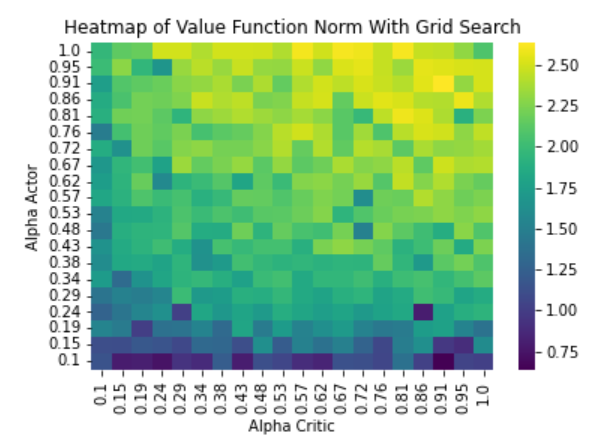

In [11]:
# Bayesian optimization method

def bayesian_optimization(
        mdp: MazeMDPEnv,
        nb_episodes: int = 100,
        timeout: int = 50,
        nb_repeats: int = 1,
        n_trials: int = 400,
        render: bool = False,
        plot_heatmap: bool = True
) -> tuple[tuple[float, float], list[tuple[float, float, float]]]:
    def objective(trial):
        alpha_critic = trial.suggest_float('alpha_critic', 0.1, 1)
        alpha_actor = trial.suggest_float('alpha_actor', 0.1, 1)

        v_norms_repeat = []
        for _ in range(nb_repeats):
            v, v_norms, time_list = naive_actor_critic(mdp, alpha_critic, alpha_actor, nb_episodes, timeout, render)
            v_norms_repeat.append(v_norms[-1])

        avg_v_norm = np.mean(v_norms_repeat)
        return avg_v_norm
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    best_params = (study.best_params['alpha_critic'], study.best_params['alpha_actor'])
    # results = [(trial.params['alpha_critic'], trial.params['alpha_actor'], trial.value) for trial in study.trials]
    results = [(round(trial.params['alpha_critic'], 2), round(trial.params['alpha_actor'], 2), trial.value) for trial in study.trials]

    if plot_heatmap:
        arr = np.array(results)
        plt.clf()
        plt.scatter(arr[:,0],arr[:,1],c=arr[:,2],cmap='viridis')
        plt.title('Heatmap of Value Function Norm With Bayesian Optimization')
        plt.xlabel('Alpha Critic')
        plt.ylabel('Alpha Actor')
        plt.show()
        plt.savefig('heatmap_bayesian.png')
    return best_params, results

best_params_bayesian, results_bayesian = bayesian_optimization(env.unwrapped,nb_repeats=1)
print(best_params_bayesian)
print(np.max(results_bayesian))


[I 2024-10-03 22:19:16,229] A new study created in memory with name: no-name-6d0359d5-a25f-470f-b0d6-2f0752b01925
[I 2024-10-03 22:19:16,413] Trial 0 finished with value: 2.096237966437067 and parameters: {'alpha_critic': 0.1215128121139998, 'alpha_actor': 0.98911319101538}. Best is trial 0 with value: 2.096237966437067.
[I 2024-10-03 22:19:16,530] Trial 1 finished with value: 2.73280888713072 and parameters: {'alpha_critic': 0.6066355830983228, 'alpha_actor': 0.32836246212534215}. Best is trial 1 with value: 2.73280888713072.
[I 2024-10-03 22:19:16,677] Trial 2 finished with value: 2.204783760122129 and parameters: {'alpha_critic': 0.1813881870376205, 'alpha_actor': 0.16767863589031684}. Best is trial 1 with value: 2.73280888713072.
[I 2024-10-03 22:19:16,762] Trial 3 finished with value: 2.6504122987649668 and parameters: {'alpha_critic': 0.3200081776133815, 'alpha_actor': 0.3182248112487931}. Best is trial 1 with value: 2.73280888713072.
[I 2024-10-03 22:19:16,911] Trial 4 finished 

(0.9421983351601867, 0.8255969278739612)
3.0995435457592917


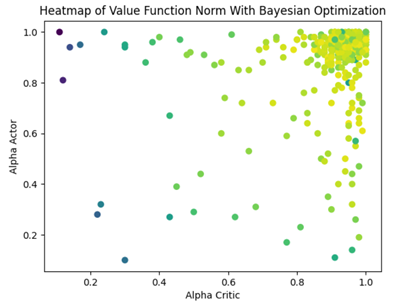

# Step 3: Statistical tests

Now you have to compare the performance of the actor-critic algorithm tuned
with all the best hyper-parameters you found before, using statistical tests.

The functions below are provided to run Welch's T-test over learning curves.
They have been adapted from a github repository: https://github.com/flowersteam/rl_stats
You don't need to understand them in detail (though it is always a good idea to try to understand more code).

In [12]:
from scipy.stats import ttest_ind
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats
from scipy.stats import ttest_ind

In [13]:
def compute_central_tendency_and_error(id_central, id_error, sample):

    try:
        id_error = int(id_error)
    except:
        pass

    if id_central == "mean":
        central = np.nanmean(sample, axis=1) 
    elif id_central == "median":
        central = np.nanmedian(sample, axis=1)
    else:
        raise NotImplementedError

    if isinstance(id_error, int):
        low = np.nanpercentile(sample, q=int((100 - id_error) / 2), axis=1)
        high = np.nanpercentile(sample, q=int(100 - (100 - id_error) / 2), axis=1)
    elif id_error == "std":
        low = central - np.nanstd(sample, axis=1)
        high = central + np.nanstd(sample, axis=1)
    elif id_error == "sem":
        low = central - np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
        high = central + np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
    else:
        raise NotImplementedError

    return central, low, high

In [14]:
def run_test(test_id, data1, data2, alpha=0.05):
    """
    Compute tests comparing data1 and data2 with confidence level alpha
    :param test_id: (str) refers to what test should be used
    :param data1: (np.ndarray) sample 1
    :param data2: (np.ndarray) sample 2
    :param alpha: (float) confidence level of the test
    :return: (bool) if True, the null hypothesis is rejected
    """
    data1 = data1.squeeze()
    data2 = data2.squeeze()
    n1 = data1.size
    n2 = data2.size

    # perform Welch t-test":
    _, p = ttest_ind(data1, data2, equal_var=False)
    return p < alpha

This last function was adapted for the lab.

In [15]:
def perform_test(perf1, perf2, name1, name2, sample_size=20, downsampling_fact=5, confidence_level=0.01):

    perf1 = perf1.transpose()
    perf2 = perf2.transpose()
    nb_datapoints = perf1.shape[1]
    nb_steps = perf1.shape[0]

    legend = [name1, name2]

    # what do you want to plot ?
    id_central = 'mean' # "median"  # 
    id_error = 80  # (percentiles), also: 'std', 'sem'

    test_id = "Welch t-test"  # recommended
    
    sample1 = perf1[:, np.random.randint(0, nb_datapoints, sample_size)]
    sample2 = perf2[:, np.random.randint(0, nb_datapoints, sample_size)]

    steps = np.arange(0, nb_steps, downsampling_fact)
    sample1 = sample1[steps, :]
    sample2 = sample2[steps, :]

    # test
    sign_diff = np.zeros([len(steps)])
    for i in range(len(steps)):
        sign_diff[i] = run_test(
            test_id, sample1[i, :], sample2[i, :], alpha=confidence_level
        )

    central1, low1, high1 = compute_central_tendency_and_error(
        id_central, id_error, sample1
    )
    central2, low2, high2 = compute_central_tendency_and_error(
        id_central, id_error, sample2
    )

    # plot
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    lab1 = plt.xlabel("training steps")
    lab2 = plt.ylabel("performance")

    plt.plot(steps, central1, linewidth=10)
    plt.plot(steps, central2, linewidth=10)
    plt.fill_between(steps, low1, high1, alpha=0.3)
    plt.fill_between(steps, low2, high2, alpha=0.3)
    leg = ax.legend(legend, frameon=False)

    # plot significative difference as dots
    idx = np.argwhere(sign_diff == 1)
    y = max(np.nanmax(high1), np.nanmax(high2))
    plt.scatter(steps[idx], y * 1.05 * np.ones([idx.size]), s=100, c="k", marker="o")

    # style
    for line in leg.get_lines():
        line.set_linewidth(10.0)
    ax.spines["top"].set_linewidth(5)
    ax.spines["right"].set_linewidth(5)
    ax.spines["bottom"].set_linewidth(5)
    ax.spines["left"].set_linewidth(5)

    plt.savefig(
        f"./{name1}_{name2}.png", bbox_extra_artists=(leg, lab1, lab2), bbox_inches="tight", dpi=100
    )
    # plt.show()

## Exercise 3

As hyper-parameters, you will use:

- naive tuning, that is a pair (0.5, 0.5) for the actor and critic learning rates,
- the best hyper-parameters you found with the different tuning algorithms you used before.

### 1. For each set of hyper-parameters, collect a large dataset of learning curves.

We suggest using 150 training episodes.

### 2. Perform statistical comparisons

- Take two datasets of learning curves obtained with the hyper-parameters sets that you found with different tuning algorithms.
- Use the ``` perform_test(...)``` function to compare each possible pair of sets.

You should obtain an image for each pair you have tried.
In this image, black dots signal the time step where there is a statistically significant difference between two learning curves.

 ### 3. Conclude.

In [16]:
# Exercise 3.1

nb_episodes = 150
nb_repeats = 10

alpha_critic, alpha_actor = (0.5, 0.5)
alpha_critic_grid,alpha_actor_grid = best_params_grid
alpha_critic_bayesian,alpha_actor_bayesian = best_params_bayesian

Lists_1,Lists_2,Lists_3 = [],[],[]
for _ in range(nb_repeats):
    v_1, v_norms_1, time_list_1 = naive_actor_critic(env.unwrapped,alpha_critic=alpha_critic, alpha_actor=alpha_actor, nb_episodes=nb_episodes, render=False)
    v_2, v_norms_2, time_list_2 = naive_actor_critic(env.unwrapped,alpha_critic=alpha_critic_grid, alpha_actor=alpha_actor_grid,nb_episodes=nb_episodes, render=False)
    v_3, v_norms_3, time_list_3 = naive_actor_critic(env.unwrapped,alpha_critic=alpha_critic_bayesian, alpha_actor=alpha_actor_bayesian, nb_episodes=nb_episodes, render=False)
    Lists_1.append(time_list_1)
    Lists_2.append(time_list_2)
    Lists_3.append(time_list_3)


In [17]:
# Exercise 3.2

learning_curves = {}

learning_curves["naive"] = np.array(Lists_1)
learning_curves["grid"] = np.array(Lists_2)
learning_curves["bayesian"] = np.array(Lists_3)

comparaison_results = {}
for name1 in learning_curves.keys():
    for name2 in learning_curves.keys():
        if name1 != name2:
            comparaison_results[(name1, name2)] = perform_test(
                learning_curves[name1],
                learning_curves[name2],
                name1 = name1,
                name2 = name2,
                confidence_level=0.05,
            )

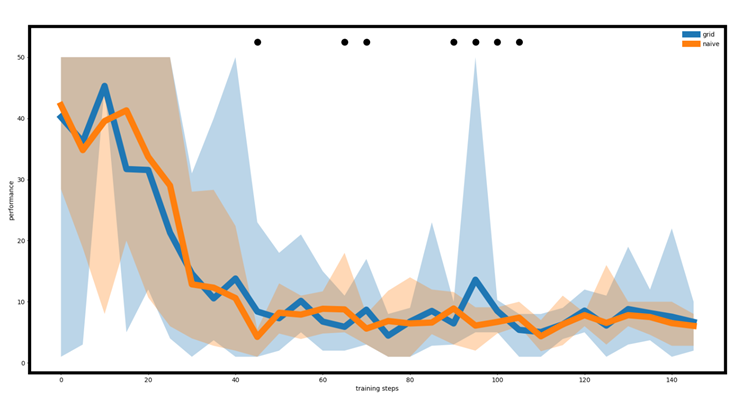

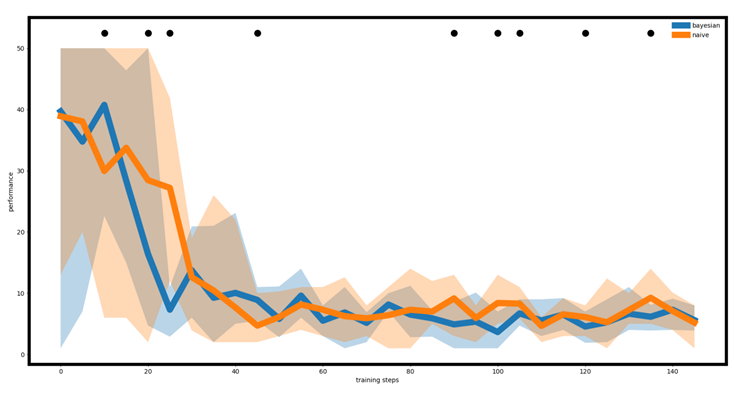

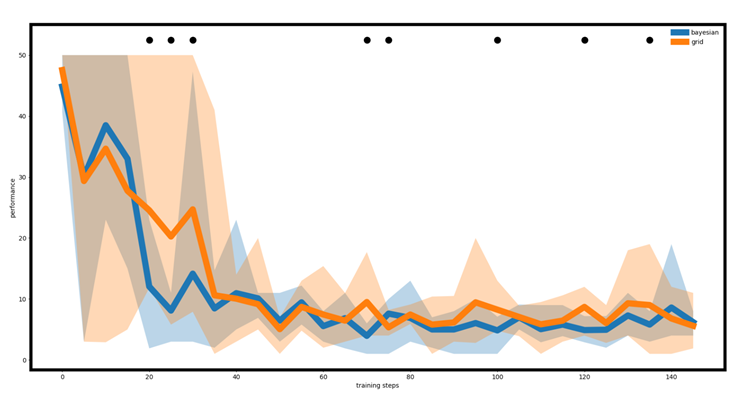

# Lab report

Your report should contain:
- your source code (probably this notebook), do not forget to put your names on top of the notebook,
- in a separate pdf file with your names in the name of the file:
    + a detailed enough description of the choices you have made: the parameters you have set, the libraries you have used, etc.,
    + the heatmaps obtained using the hyper-parameters tuning algorithms that you have used,
    + the figures resulting from performing Welch's T-test using the best hyper-parameters from the above approaches,
    + your conclusion from these experiments.

Beyond the elements required in this report, any additional studies will be rewarded.
For instance, you can try using a Q-function as critic, using random search as hyper-parameters tuning algorithm,
using more challenging environments, etc.